In [40]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from scipy.stats import ttest_1samp
from collections import defaultdict
from pathlib import Path
import os

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 130)

notebook_path = Path(os.getcwd())
results_path = notebook_path.parent.parent # we should be in /netdeployonnx/client/experiment.ipynb, so we end up in /
figures_path = results_path.parent.parent / "documentation" / "figures"
print(results_path, figures_path)
assert results_path.exists()
assert figures_path.exists(), f"{figures_path} does not exist"
assert str(figures_path).endswith('/_Masterarbeit_SS24/documentation/figures')

/home/vscode/_Masterarbeit_SS24/hannah-env/service /home/vscode/_Masterarbeit_SS24/documentation/figures


In [41]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (5 Layer)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944, # 200_000
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

In [42]:
df = load_results(results_path / "results_network.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()
df['network_size'] = df['option_network_name'].apply(lambda x:weights[x])
df = df.sort_values(by=['network_size'])

/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


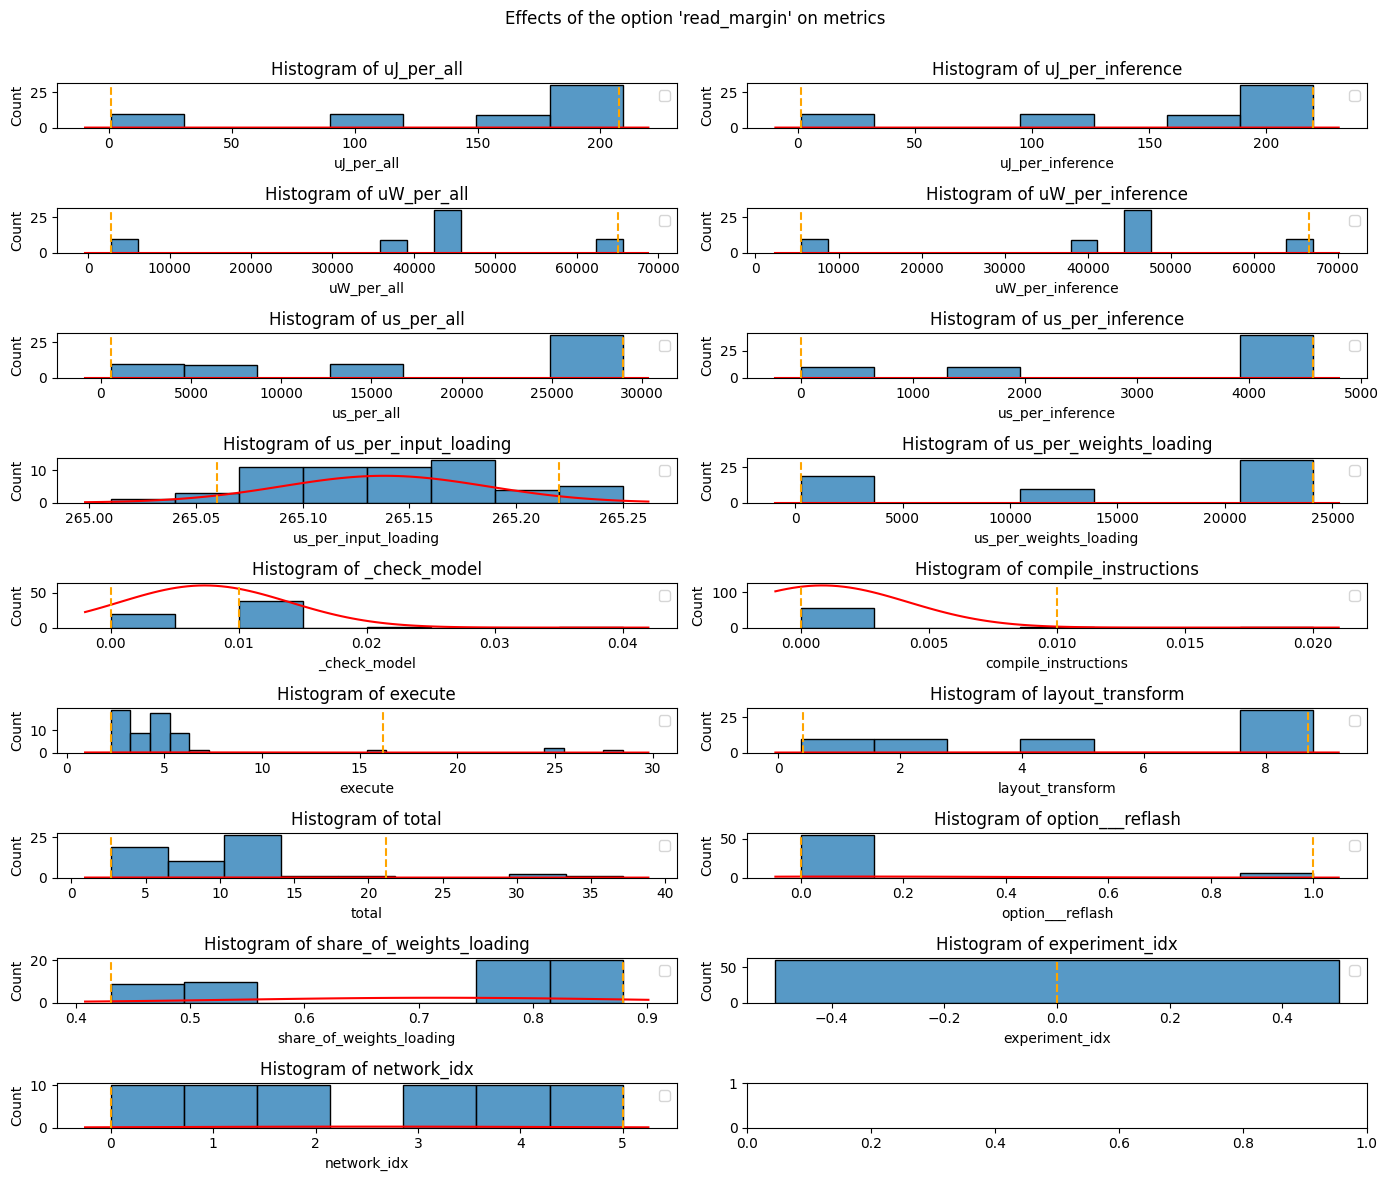

In [43]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


## Metrics between nets and flashing vs not flashing

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)]


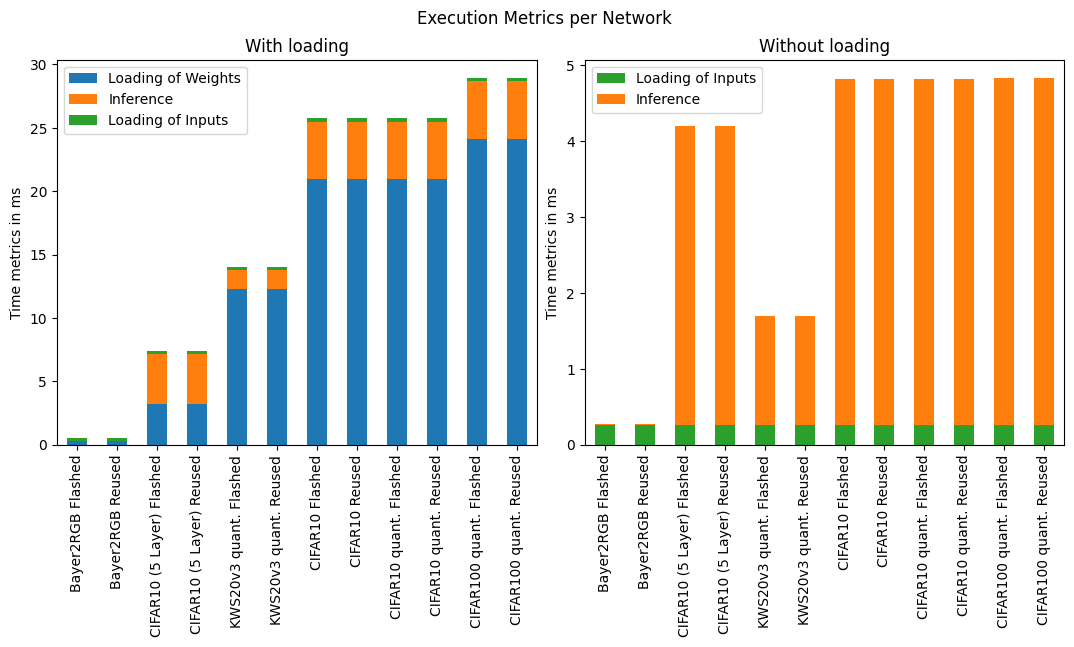

In [44]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])

for k in ['inference','weights_loading', 'input_loading']:
    df_percents[nice_metrics[k]] = df_filtered[f'us_per_{k}'] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option']).apply(lambda x: x / 1000, axis=1)
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean().sort_values(by=['network_size'])

df_percents_grouped.index = [f'{net} {option}' for net, option in df_percents_grouped.index]

fig, axes = plt.subplots(1, 2, figsize=(13,5))
# Plot the stacked bar chart
df_percents_grouped_displayed = df_percents_grouped[[nice_metrics[k] for k in ['weights_loading', 'inference','input_loading', ]]]
ax1 = df_percents_grouped_displayed.plot(kind='bar', stacked=True, ax=axes[0])
#colors = [patch.get_facecolor() for patch in ax1.patches]
colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)]
color_for_metric={
    'weights_loading':colors[0],
    'inference':colors[1],
    'input_loading':colors[2],
}
colors = colors[::len(colors)//3]
print(colors)

df_percents_grouped_withoutweights = df_percents_grouped_displayed.drop(columns=[nice_metrics['weights_loading']])[[nice_metrics[k] for k in ['input_loading', 'inference', ]]]
df_percents_grouped_withoutweights.plot(kind='bar', stacked=True, ax=axes[1], color=[color_for_metric[metric] for metric in ['input_loading', 'inference']])


axes[0].set_ylabel('Time metrics in ms')
axes[1].set_ylabel('Time metrics in ms')
axes[0].set_title('With loading')
axes[1].set_title('Without loading')
# axes[1].set_yticks([x*0.6 for x in range(4,8)])
# axes[1].set_yticklabels([f'{(x//0.6)-6:2.0f}'  for x in range(4,8)])
# axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Execution Metrics per Network')
plt.savefig(figures_path / "05_execution_metrics_per_network.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [45]:
# from functools import reduce
# data = (df_percents_grouped_displayed[nice_metrics['inference']] * 100).round().astype(int)
# print(data)
# gcds = pd.cut(data, bins=10, labels=False)
# df_percents_grouped_displayed[nice_metrics['inference']] / gcds
# gcds

     Option            Network  network_size  Inference  Loading of Weights  Loading of Inputs
0   Flashed  CIFAR10 (5 Layer)         42944    3940.04             3184.26             265.17
1    Reused  CIFAR10 (5 Layer)         42944    3940.04             3181.41             265.14
3    Reused  CIFAR10 (5 Layer)         42944    3940.20             3182.81             265.14
4    Reused  CIFAR10 (5 Layer)         42944    3940.41             3181.64             265.17
5    Reused  CIFAR10 (5 Layer)         42944    3940.12             3180.88             265.20
6    Reused  CIFAR10 (5 Layer)         42944    3940.44             3182.73             265.17
7    Reused  CIFAR10 (5 Layer)         42944    3940.20             3181.54             265.17
8    Reused  CIFAR10 (5 Layer)         42944    3940.23             3180.64             265.14
9    Reused  CIFAR10 (5 Layer)         42944    3940.42             3182.68             265.14
10  Flashed            CIFAR10        302602    45

/tmp/ipykernel_4135539/2943723835.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
/tmp/ipykernel_4135539/2943723835.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
/tmp/ipykernel_4135539/2943723835.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])
/tmp/ipykernel_4135539/2943723835.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])


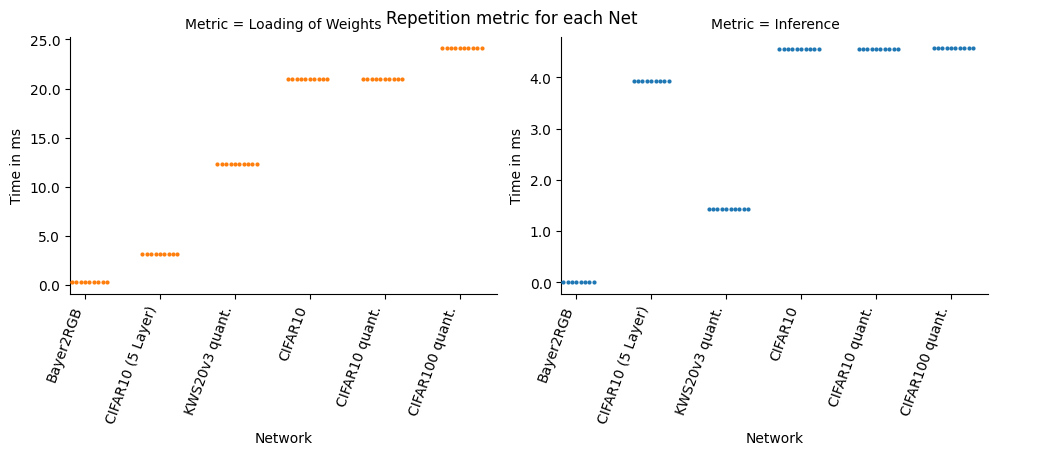

In [46]:
repetition_per_network = df_percents.copy()
#print(repetition_per_network)

# Drop NaNs for the relevant columns
metrics = ['Loading of Weights', 'Inference',] #, 'Loading of Inputs'
df_clean = repetition_per_network.dropna(subset=metrics)

print(df_clean)

# Melt the DataFrame to long format for easier plotting
df_melted = df_clean.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=metrics, var_name='Metric', value_name='Value')

# Use FacetGrid to create separate plots for each network
g = sns.FacetGrid(df_melted, col='Metric', sharey=False, height=3.5, aspect=1.5, margin_titles=True)

palette = sns.color_palette("Greys", n_colors=6)
# Map violinplot to the grid for each metric
g.map_dataframe(sns.swarmplot, x='Network', y='Value', size=3)
#sns.swarmplot(x='Network', y='Value', hue='Metric', data=df_melted)


# Rotate the x-axis labels
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
# Adjust x-axis limits if needed for compactness
for i, ax in enumerate(g.axes.flatten()):
    ax.set_xlim(-0.2, 5.5)  # Adjust based on number of metrics
    metric = ['inference', 'weights_loading'][i]
    for coll in ax.collections:
        coll.set_color(color_for_metric[metric])
    # print(ax.get_yticks())
    ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])
    ax.set_ylabel('Time in ms')

# Add a legend and adjust the layout
g.add_legend()
fig = g.fig
fig.subplots_adjust(wspace=0.15)
fig.suptitle("Repetition metric for each Net")
fig.savefig(figures_path / "05_repetition_metrics_per_network.pdf", format='pdf', bbox_inches='tight')

             Network              Metric    Value  Mean_Value  Absolute Precision  Relative Precision
0          Bayer2RGB  Loading of Weights   276.44     276.432               0.008            0.002894
1          Bayer2RGB  Loading of Weights   276.44     276.432               0.008            0.002894
2          Bayer2RGB  Loading of Weights   276.41     276.432              -0.022           -0.007959
3          Bayer2RGB  Loading of Weights   276.44     276.432               0.008            0.002894
4          Bayer2RGB  Loading of Weights   276.41     276.432              -0.022           -0.007959
..               ...                 ...      ...         ...                 ...                 ...
113  CIFAR100 quant.           Inference  4569.43    4569.378               0.052            0.001138
114  CIFAR100 quant.           Inference  4569.54    4569.378               0.162            0.003545
115  CIFAR100 quant.           Inference  4569.19    4569.378              -0.188 

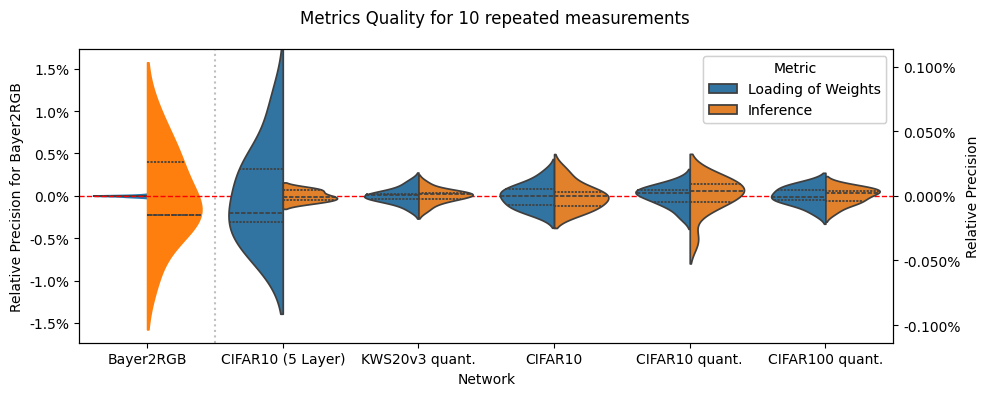

In [47]:
# Melt the DataFrame to long format for easier plotting
df_melted = df_clean.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=metrics, var_name='Metric', value_name='Value')


mean_values = df_melted.dropna(subset=['Value']).groupby(['Network', 'Metric'])['Value'].mean().reset_index()
mean_values.rename(columns={'Value': 'Mean_Value'}, inplace=True)

# Step 2: Merge to get the mean in the original DataFrame
df_with_mean = df_melted.merge(mean_values, on=['Network', 'Metric'])

# Step 3: Calculate the relative precision
df_with_mean['Absolute Precision'] = df_with_mean['Value'] - df_with_mean['Mean_Value']
df_with_mean['Relative Precision'] = df_with_mean['Absolute Precision'] / df_with_mean['Mean_Value'] * 100 # in percent

# Step 4: Compute the logarithmic relative precision
#df_with_mean['Log_Relative_Precision'] = np.log1p(df_with_mean['Relative_Precision'])

print(df_with_mean)

# Step 5: Calculate the t-test correction
# Grouping by Network and Metric to get mean and standard deviation
group_stats = df_with_mean.groupby(['Network', 'Metric'])['Relative Precision'].agg(['mean', 'std', 'count']).reset_index()

# Step 6: Calculate the t-statistic and corrected values (e.g., confidence interval)
# Assuming you want the confidence interval around the mean
confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2., group_stats['count'] - 1)  # Two-tailed
group_stats['margin_of_error'] = t_critical * (group_stats['std'] / np.sqrt(group_stats['count']))
group_stats['Lower_CI'] = group_stats['mean'] - group_stats['margin_of_error']
group_stats['Upper_CI'] = group_stats['mean'] + group_stats['margin_of_error']

print(group_stats)

# Step 7: Create violin plots for logarithmic relative precision with swapped axes
fig = plt.figure(figsize=(10, 4))
if 1:
    ax = sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] == "Bayer2RGB"], 
                   split=True,
                   width=0.8,        # Increase width (default is usually 0.8)
                   inner='quartile', # Shows quartile marks inside
                   density_norm='width',
                   )  # Set inner=None to avoid drawing the boxplot
    ax.set_ylabel("Relative Precision for Bayer2RGB")
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.1f}%')
    for metricindex, coll in enumerate(ax.collections):
        metric = ['weights_loading', 'inference'][metricindex]
        coll.set_color(color_for_metric[metric])
        print(coll.get_label())

    # now the rest of the plots
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    ax2 = ax.twinx()
    sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] != "Bayer2RGB"], 
                   split=True,
                   width=0.8,        # Increase width (default is usually 0.8)
                   inner='quartile', # Shows quartile marks inside
                   density_norm='width',
                   ax=ax2,
                   )  # Set inner=None to avoid drawing the boxplot
    ax2.set_ylabel("Relative Precision")
    ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}%')
    for metricindex, coll in enumerate(ax.collections):
        metric = ['weights_loading', 'inference'][metricindex]
        coll.set_color(color_for_metric[metric])
    

    ylim1 = ax.get_ylim()
    ylim2 = ax2.get_ylim()
    
    # Find the relative position of 0 in data coordinates for both axes
    zero_pos1 = -ylim1[0] / (ylim1[1] - ylim1[0])  # relative position of 0 in axis 1
    zero_pos2 = -ylim2[0] / (ylim2[1] - ylim2[0])  # relative position of 0 in axis 2
    
    # if the scaling of ylim1 is more favorable, use by setting extendable_axis = ax2
    extendable_axis = ax2  # or ax, depending on which one you want to move
    current_range = ylim2[1] - ylim2[0]  # preserve the range
    
    # Shift the limits to align 0 while preserving the range
    ylim_min = -(zero_pos1 * current_range)
    ylim_max = ylim_min + current_range
    
    extendable_axis.set_ylim(ylim_min, ylim_max)
else:
    sns.swarmplot(x='Network', y='Relative_Precision', hue='Metric', data=df_with_mean)

# Set x-ticks and rotate labels
#plt.xticks(rotation=45)
fig.suptitle('Metrics Quality for 10 repeated measurements')
ax.set_xlabel('Network')
ax.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a line at y=0 for reference
ax2.legend(title='Metric')
fig.tight_layout()
fig.savefig(figures_path / "05_repetition_metrics_per_network_accuracy.pdf", format='pdf')

In [48]:
from scipy.stats import t
from scipy.stats import norm

# Hypotheses
H0 = "The mean relative precision is 0, indicating sufficient accuracy."
H1 = "The mean relative precision is not 0, indicating ====insufficient==== accuracy."

# Example DataFrame structure
# df = pd.DataFrame({
#     'Network': ['A', 'A', 'B', 'B', 'C', 'C', ...],
#     'Relative Precision': [0.001, -0.002, 0.0005, -0.001, 0.0012, ...]
# })
n=10
nsigma = 1
probability_sigma = norm.cdf(nsigma) - norm.cdf(-nsigma)
alpha = 1 - probability_sigma

# Perform t-test for each network category
results = {}
for network, group in df_with_mean.groupby(['Network', 'Metric']):
    sample = group['Value']
    
    # Calculate mean and standard deviation
    sample_mean = sample.mean()
    sample_std = sample.std(ddof=1)  # Sample standard deviation
    n = len(sample)

    # Calculate the critical t-value
    t_critical = t.ppf((1+alpha) / 2, df=n - 1)

    # Calculate the margin of error
    margin_of_error = t_critical * (sample_std / (n ** 0.5))
    
    # Calculate the confidence interval
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    
    # Check if the sample mean is inside the confidence interval
    is_inside_interval: bool = confidence_interval[0] <= sample_mean <= confidence_interval[1]
    
    # Check if all values match (i.e., are within the confidence interval)
    all_values_match: bool = [confidence_interval[0] <= value <= confidence_interval[1] for value in sample]

     # Define confidence interval using min and max of the sample
    min_value = sample.min()
    max_value = sample.max()
    
    # Calculate confidence in sigma for n=1 based on min and max
    # Calculate distances from the mean to the bounds of the min and max
    distance_to_min = (sample_mean - min_value) / (sample_std / (1 ** 0.5))
    distance_to_max = (max_value - sample_mean) / (sample_std / (1 ** 0.5))

    # Calculate the confidence in sigma for n=1 in percentage
    confidence_sigma = min(distance_to_min, distance_to_max)
    confidence_percent = norm.cdf(confidence_sigma) - norm.cdf(-confidence_sigma)

    # Calculate the t-statistic and p-value for a one-sample t-test against the mean
    # For a one-sample test, we'll use the overall sample mean as the hypothesized mean
    hypothesized_mean = sample_mean
    t_statistic = (sample_mean - hypothesized_mean) / (sample_std / (n ** 0.5))  # This will be 0 since it's sample_mean vs itself
    p_value = 2 * stats.t.sf(abs(t_statistic), df=n - 1)  # Two-tailed test

    print(f"Network {network}:")
    print(f"  Confidence Interval (nsigma={nsigma}): {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
    print(f"  Sample Mean: {sample_mean:.4f} is inside interval: {is_inside_interval}")
    print(f"  All values match: {all_values_match}")
    print(f"  Confidence in sigma for n=1: {confidence_sigma:.2f} ({confidence_percent}%)")
    print(f"  T-Statistic: {t_statistic:.4f}, P-Value: {p_value:.4f}\n")


confidence_level = 0.95

# Function to calculate confidence interval for each group
def calculate_confidence_interval(group):
    n = len(group)
    if n < 2:  # Ensure we have enough data points
        return (np.nan, np.nan)
    
    mean = np.mean(group)
    std_dev = np.std(group, ddof=1)  # Sample standard deviation
    t_value = stats.t.ppf((1 + confidence_level) / 2, n - 1)  # t critical value
    
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    return (mean - margin_of_error, mean + margin_of_error)

# Group by 'Network' and 'Metric', then calculate confidence intervals
confidence_intervals = df_with_mean.groupby(['Network', 'Metric'])['Value'].apply(calculate_confidence_interval)

# Convert result to DataFrame for better visualization
confidence_intervals_df = confidence_intervals.reset_index(name='Confidence Interval')
print(confidence_intervals_df)

# Function to calculate confidence level based on min and max
def calculate_confidence_level(group):
    n = len(group)
    if n < 2:
        return np.nan  # Not enough data for confidence level
    
    sample_min = np.min(group)
    sample_max = np.max(group)
    mean = np.mean(group)
    std_dev = np.std(group, ddof=1)

    # Calculate the margin of error from the range
    half_range = (sample_max - sample_min) / 2
    
    # Calculate the t-value
    t_value = half_range / (std_dev / np.sqrt(n))

    # Calculate the cumulative probability for the t-value
    p_value = stats.t.cdf(t_value, df=n - 1)
    
    # Since we want a two-tailed confidence level
    confidence_level = p_value * 2
    
    return confidence_level

# Group by 'Network' and 'Metric', then calculate confidence levels
confidence_levels = df_with_mean.groupby(['Network', 'Metric'])['Value'].apply(calculate_confidence_level)

# Convert result to DataFrame for better visualization
confidence_levels_df = confidence_levels.reset_index(name='Confidence Level')
print(confidence_levels_df)

Network ('Bayer2RGB', 'Inference'):
  Confidence Interval (nsigma=1): 4.3470 to 4.3530
  Sample Mean: 4.3500 is inside interval: True
  All values match: [False, False, False, False, False, False, False, False, False, False]
  Confidence in sigma for n=1: 1.77 (0.9231567559663427%)
  T-Statistic: 0.0000, P-Value: 1.0000

Network ('Bayer2RGB', 'Loading of Weights'):
  Confidence Interval (nsigma=1): 276.4290 to 276.4350
  Sample Mean: 276.4320 is inside interval: True
  All values match: [False, False, False, False, False, False, False, False, False, False]
  Confidence in sigma for n=1: 1.69 (0.9086260632636196%)
  T-Statistic: 0.0000, P-Value: 1.0000

Network ('CIFAR10', 'Inference'):
  Confidence Interval (nsigma=1): 4556.2229 to 4556.3451
  Sample Mean: 4556.2840 is inside interval: True
  All values match: [False, False, True, False, False, False, True, False, False, False]
  Confidence in sigma for n=1: 1.21 (0.7739931459480824%)
  T-Statistic: 0.0000, P-Value: 1.0000

Network ('C

## Metrics between nets and flashing vs not flashing

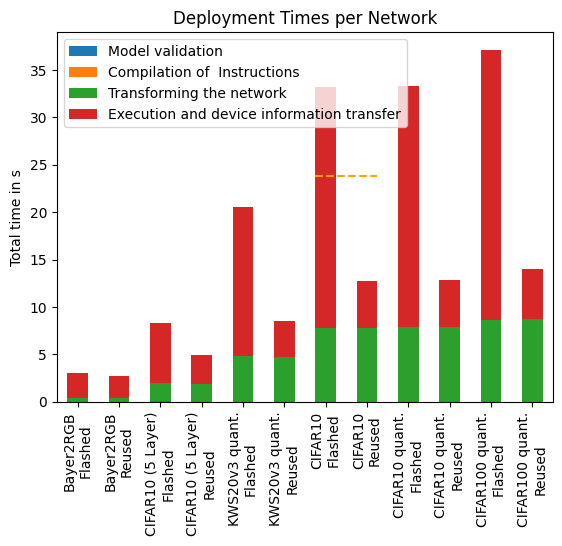

In [49]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])

selected_fields=['_check_model', 'compile_instructions', 'layout_transform', 'execute', ]

for k in selected_fields:
    df_percents[nice_colnames[k]] = df_filtered[k] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option'])
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean().sort_values(by=['network_size'])

df_percents_grouped.index = [f'{net}\n{option}' for net, option in df_percents_grouped.index]


# Plot the stacked bar chart
df_percents_grouped[[nice_colnames[k] for k in selected_fields]].plot(kind='bar', stacked=True)

offset = df_percents_grouped[nice_colnames['layout_transform']]['CIFAR10\nFlashed']

ax_measured_comp = plt.plot(np.linspace(5.75, 7.25, 100),
         [16+offset]*100,
         color='orange', linestyle='--', label='typ. compile time')

plt.ylabel('Total time in s')
plt.title('Deployment Times per Network')
plt.savefig(figures_path / "05_deployment_times.pdf", format='pdf', bbox_inches='tight')

Average flashing overhead relative to Network size: 280.75%
fit coefficients: [1.17256295e-05 5.26569615e-01]


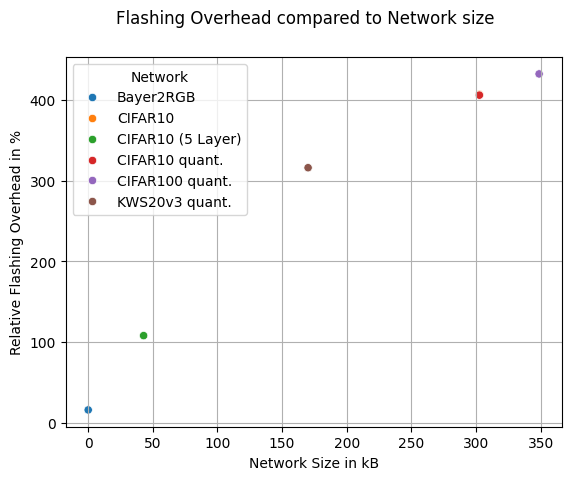

In [50]:
# print(df_percents)
# Group by 'Network' and calculate mean of 'Execution' for both "Flashed" and "Reused"
flashed_mean = df_percents[df_percents['Option'] == "Flashed"].groupby('Network')[nice_colnames['execute']].mean()
reused_mean = df_percents[df_percents['Option'] == "Reused"].groupby('Network')[nice_colnames['execute']].mean()
network_size_mean= df_percents.groupby('Network')['network_size'].mean()

# Compare the means per network
comparison = pd.DataFrame({
    'Flashed Mean': flashed_mean,
    'Reused Mean': reused_mean,
    'Overhead in s': (flashed_mean - reused_mean),
    'Relative Flashing Overhead': (flashed_mean - reused_mean) / reused_mean,
    'Network Size': network_size_mean,
    'Network Size in kB': network_size_mean/1000,
    'realtive Network Size': network_size_mean.apply(lambda x: 100*x/network_size_mean.max()),
})
comparison['Relative Flashing Overhead in %'] = comparison['Relative Flashing Overhead'] *100
comparison['Relative Flashing Overhead\n in % to logarithmic Network Size'] = comparison['Relative Flashing Overhead in %'] / np.log(comparison['Network Size in kB'])
# print(comparison)
flash_overhead_value = (comparison['Relative Flashing Overhead'] *100).mean()
print(f"Average flashing overhead relative to Network size: {flash_overhead_value:2.2f}%")

#=============================================

fitted = np.polyfit(comparison['Network Size'], comparison['Relative Flashing Overhead'], 1)
print("fit coefficients:", fitted)

# Plotting the scatter and fitted log curve
# fig, axes = plt.subplots(1,2,figsize=(12,3))
ax = sns.scatterplot(
    # ax=axes[0],
    data=comparison, x='Network Size in kB', y='Relative Flashing Overhead in %', hue='Network')
# ax2 = sns.scatterplot(ax=axes[1],data=comparison, x='Network Size in kB', y='Relative Flashing Overhead\n in % to logarithmic Network Size', hue='Network')
ax.grid()
# ax2.grid()
# Generate x values for plotting the log fit
x = np.linspace(min(comparison['Network Size']), max(comparison['Network Size']), 1000)

# Plot the logarithmic fit
#plt.plot(x, np.polyval(x, fitted), label="Log fit", color='orange')

#plt.legend()
plt.suptitle('Flashing Overhead compared to Network size')
plt.savefig(figures_path / "05_deployment_times_overhead.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_4135539/3676522475.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_xticks()])


original const: 70.2
fitted const: ['-0.00002', '74.08074', '63294.09880']
constant time offset: 63.294 µs
test: 25.928260093838226


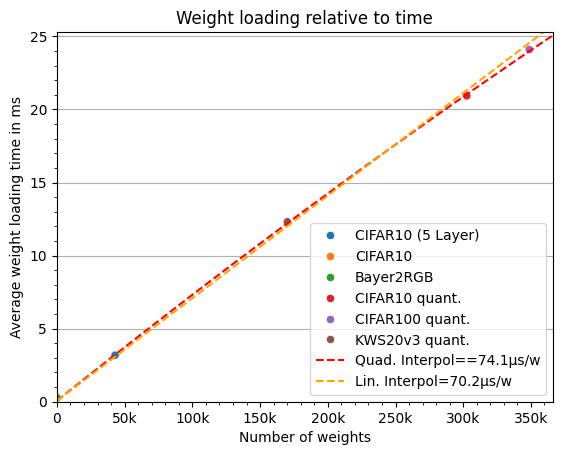

In [51]:
# plot time per weight as a plot with the 'network_name' as hue
df_per_weights = df_filtered.copy().dropna(subset=['us_per_weights_loading'])
df_per_weights['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_per_weights['weight_count'] = df['option_network_name'].apply(lambda x: weights[x])
df_per_weights['ms_per_weights_loading'] = df_per_weights['us_per_weights_loading'].apply(lambda x: x/1000)
df_per_weights['perform'] = df_per_weights['weight_count'] / (df_per_weights['ms_per_weights_loading'] - 0.0635)# offset 63.5 µs for linear interpol

ax = sns.scatterplot(data=df_per_weights, x='weight_count', y='ms_per_weights_loading', hue='Network',)
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_xticks()])

loading_const_filtered = df_per_weights[df_per_weights['weight_count'] > 10000]
loading_constant_original = 1.0/(df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean()
print(f"original const: {loading_constant_original*1e6:2.1f}")

fitted_loading_const = np.polyfit(loading_const_filtered['weight_count'], loading_const_filtered['ms_per_weights_loading'], 2)
print(f"fitted const:", [f"{flc*1e6:2.5f}" for flc in fitted_loading_const])
loading_constant = fitted_loading_const[-2]
loading_constant_offset = fitted_loading_const[-1]
print(f"constant time offset: { loading_constant_offset*1e3:2.3f} µs")
print(f"test: {350000*loading_constant}")


df_per_weights['offset'] = df_per_weights['ms_per_weights_loading'] - df_per_weights['weight_count'] * loading_constant
df_per_weights['offset_part'] =df_per_weights['offset'] / df_per_weights['ms_per_weights_loading'] 
# print(df_per_weights[['Network','offset','offset_part']])
# print(df_per_weights.groupby('Network').mean()['offset_part'])

x_for_loading_constant = np.linspace( ax.get_xlim()[0], ax.get_xlim()[1], 100)
ax.yaxis.grid(True)
ax.minorticks_on()
ax2 = plt.plot(x_for_loading_constant, np.polyval(fitted_loading_const, x_for_loading_constant),
         color='red', linestyle='--', label=f'Quad. Interpol=={loading_constant*1e6:0.1f}µs/w'
         )
ax2 = plt.plot(x_for_loading_constant, x_for_loading_constant*loading_constant_original+loading_constant_offset,
         color='orange', linestyle='--', label=f'Lin. Interpol={loading_constant_original*1e6:0.1f}µs/w'
         )

ax.legend(loc='lower right')

plt.xlabel("Number of weights")
plt.ylabel("Average weight loading time in ms")
plt.title('Weight loading relative to time')
# plt.legend()

# mean = (df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean() # 14232
# df_per_weights[['weight_count', 'Network', 'us_per_weights_loading','perform']]

plt.savefig(figures_path / "05_weight_loading_relative_to_time.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_4135539/1646336942.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_yticks()])


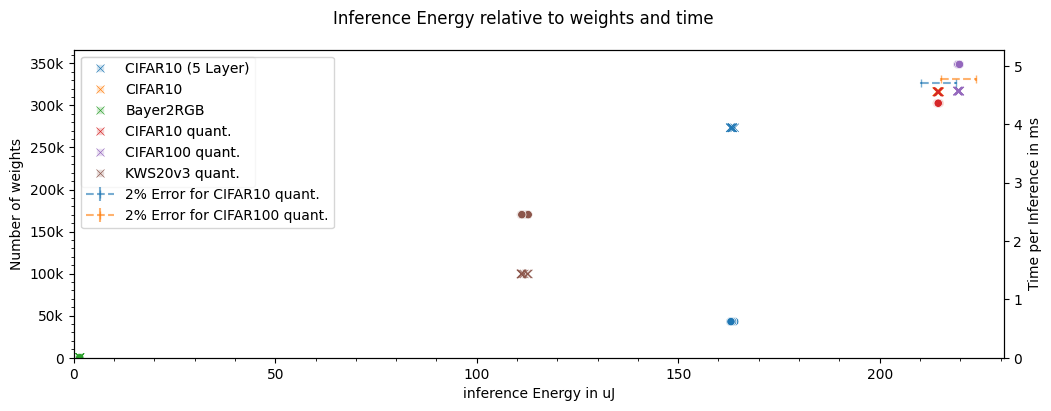

In [52]:
# plot time per weight as a plot with the 'network_name' as hue
df_per_weights = df_filtered.copy().dropna(subset=['us_per_weights_loading'])
df_per_weights['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_per_weights['weight_count'] = df['option_network_name'].apply(lambda x: weights[x])
df_per_weights['uJ_per_inference'] = df_per_weights['uJ_per_inference'].apply(lambda x: x)
df_per_weights['us_per_inference'] = df_per_weights['us_per_inference'].apply(lambda x: x/1000)
df_per_weights['perform'] = df_per_weights['weight_count'] / df_per_weights['uJ_per_inference']

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes = [axes]

ax = sns.scatterplot(data=df_per_weights, x='uJ_per_inference', y='weight_count', hue='Network',ax=axes[0])
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.legend(loc='upper left')
ax.set_yticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_yticks()])
ax2 = ax.twinx()
ax2 = sns.scatterplot(data=df_per_weights, x='uJ_per_inference', y='us_per_inference', hue='Network',ax=ax2, marker="x")
ax2.set_xlim([0, ax2.get_xlim()[1]])
ax2.set_ylim([0, ax2.get_ylim()[1]*1.1])


# ax3 = axes[1]
# ax3 = sns.scatterplot(data=df_per_weights, x='weight_count', y='us_per_inference', hue='Network',ax=ax3, marker="+")
# ax3.set_xlim([0, ax3.get_xlim()[1]])
# ax3.set_ylim([0, ax3.get_ylim()[1]*1.1])
# ax3.set_xticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax3.get_xticks()])
# ax3.legend(loc='lower right')

df_x_mean = df_per_weights.groupby('Network')[['uJ_per_inference', 'us_per_inference']].mean().reset_index()

errorbars = []
uncertainty = 2/100  # 2%
for i, (x_error_bar, y_error_bar, net) in enumerate([
    ([x*(1-uncertainty), x*(1+uncertainty)], [y]*2, net)
    for x,y,net in [
        (
            df_x_mean[df_x_mean['Network'] == net]['uJ_per_inference'].iloc[0],
            df_x_mean[df_x_mean['Network'] == net]['us_per_inference'].iloc[0]+0.1+0.05*(neti+1),
            net,
        )
        for neti, net in enumerate(['CIFAR10 quant.', 'CIFAR100 quant.'])
    ]
]):
    plt.errorbar(x_error_bar, y_error_bar, yerr=[0.02],
             fmt='|',
             color=colors[i],
             linestyle='--',
             label=f'2% Error for {net}',
             alpha=0.6)
    #errorbars.append(errorbar)

ax.set_ylabel("Number of weights")
ax2.set_ylabel("Time per Inference in ms")
ax.set_xlabel("inference Energy in uJ")
ax2.set_xlabel("Inference Energy in uJ")
fig.suptitle('Inference Energy relative to weights and time')
#fig.legend()
ax2.legend(loc='upper left')
#ax.xaxis.grid(True)
ax.minorticks_on()

# mean = (df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean() # 14232
# df_per_weights[['weight_count', 'Network', 'us_per_weights_loading','perform']]

fig.savefig(figures_path / "05_independence_inference_energy.pdf", format='pdf', bbox_inches='tight')

# compare energy per network

(-7.511246005516233, 8.835749316774512) (-2.284886913786838, 2.4477689680169825)


/tmp/ipykernel_4135539/3409069311.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='center',)


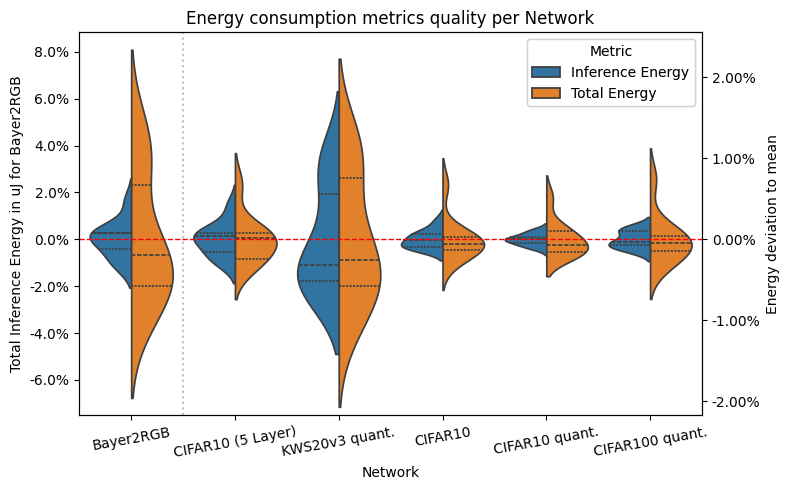

In [53]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
# df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])
df_percents['Total Energy'] =  df['uJ_per_all']
df_percents['Inference Energy'] =  df['uJ_per_inference']
df_percents_filtered = df_percents.dropna(subset=['Total Energy'])
# Melt the DataFrame to long format for easier plotting
df_melted = df_percents_filtered.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=['Inference Energy', 'Total Energy'], var_name='Metric', value_name='Value')

mean_values = df_melted.dropna(subset=['Value']).groupby(['Network', 'Metric'])['Value'].mean().reset_index()
mean_values.rename(columns={'Value': 'Mean_Value'}, inplace=True)

# Step 2: Merge to get the mean in the original DataFrame
df_with_mean = df_melted.merge(mean_values, on=['Network', 'Metric'])

# Step 3: Calculate the relative precision
df_with_mean['Absolute Precision'] = df_with_mean['Value'] - df_with_mean['Mean_Value']
df_with_mean['Relative Precision'] = df_with_mean['Absolute Precision'] / df_with_mean['Mean_Value'] * 100 # in percent

# Step 4: Compute the logarithmic relative precision
#df_with_mean['Log_Relative_Precision'] = np.log1p(df_with_mean['Relative_Precision'])

selected_fields=['_check_model', 'compile_instructions', 'layout_transform', 'execute', ]

for k in selected_fields:
    df_percents[nice_colnames[k]] = df_filtered[k] #/ df_filtered['us_per_all']

fig = plt.figure(figsize=(8,5))

if 1:
    ax = sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] == "Bayer2RGB"], 
                    split=True,
                    width=0.8,        # Increase width (default is usually 0.8)
                    inner='quartile', # Shows quartile marks inside
                    density_norm='width',
                    )  # Set inner=None to avoid drawing the boxplot
    ax.set_ylabel('Total Inference Energy in uJ for Bayer2RGB')
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.1f}%')
    # for metricindex, coll in enumerate(ax.collections):
    #     metric = ['weights_loading', 'inference'][metricindex]
    #     coll.set_color(color_for_metric[metric])
    # ax.get_legend().remove()

    # now the rest of the plots
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    ax2 = ax.twinx()
    sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] != "Bayer2RGB"], 
                    split=True,
                    width=0.8,        # Increase width (default is usually 0.8)
                    inner='quartile', # Shows quartile marks inside
                    density_norm='width',
                    ax=ax2,
                    )  # Set inner=None to avoid drawing the boxplot
    ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:.2f}%')
    ax2.get_legend().remove()

    # for metricindex, coll in enumerate(ax.collections):
    #     metric = ['weights_loading', 'inference'][metricindex]
    #     coll.set_color(color_for_metric[metric])


    ylim1 = ax.get_ylim()
    ylim2 = ax2.get_ylim()
    print(ylim1, ylim2)

    # Find the relative position of 0 in data coordinates for both axes
    zero_pos1 = -ylim1[0] / (ylim1[1] - ylim1[0])  # relative position of 0 in axis 1
    zero_pos2 = -ylim2[0] / (ylim2[1] - ylim2[0])  # relative position of 0 in axis 2

    # if the scaling of ylim1 is more favorable, use by setting extendable_axis = ax2
    extendable_axis = ax2  # or ax, depending on which one you want to move
    current_range = ylim2[1] - ylim2[0]  # preserve the range

    # Shift the limits to align 0 while preserving the range
    ylim_min = -(zero_pos1 * current_range)
    ylim_max = ylim_min + current_range

    extendable_axis.set_ylim(ylim_min, ylim_max)


    ax1.set_ylabel('Energy deviation to mean for Bayer2RGB')
    ax2.set_ylabel('Energy deviation to mean')
plt.xlabel('Network')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a line at y=0 for reference

ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='center',)
plt.legend(title='Metric', loc='upper right')
plt.title('Energy consumption metrics quality per Network')
plt.tight_layout()
plt.savefig(figures_path / "05_deployment_energy.pdf", format='pdf', bbox_inches='tight')